<a href="https://colab.research.google.com/github/pedroteche-ih/79_PT_JUN2022/blob/main/79%20DA%20PT%20JUN-2022%20Deep%20Learning%20com%20Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split

# Deep Learning

## Modelos de Classificação

In [55]:
url = 'https://raw.githubusercontent.com/pedroteche-ih/64_PT_NOV202111/main/aulas/data/tb_hotel_completa.csv'
tb_hotel = pd.read_csv(url)


## Construindo Pipelines

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [57]:
tb_hotel.select_dtypes(include = "number").columns

Index(['Unnamed: 0', 'is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'id_booking'],
      dtype='object')

In [58]:
cat_vars = [
    'hotel', 'meal', 'country', 
    'market_segment', 'distribution_channel',
    'reserved_room_type', 'assigned_room_type', 
    'deposit_type', 'customer_type'
]
num_vars = [
    'lead_time', 'stays_in_weekend_nights',
    'stays_in_week_nights', 'adults', 'children', 'babies',
    'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled','days_in_waiting_list', 
    'adr', 'required_car_parking_spaces',
    'total_of_special_requests'
]

#### Braço Numérico

In [59]:
num_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
num_scaler = StandardScaler()
num_pipeline = Pipeline([('IMPUTER', num_imputer), ('SCALER', num_scaler)])


#### Braço Categórico

In [60]:
cat_imputer = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')
ohe = OneHotEncoder(
    drop = 'first', 
    handle_unknown = 'ignore',
    sparse = False
)
cat_pipeline = Pipeline([('IMPUTER', cat_imputer), ('OHE', ohe)])

#### Pipeline Final

In [61]:
composed = ColumnTransformer([('CAT', cat_pipeline, cat_vars),
                              ('NUM', num_pipeline, num_vars)])
dataprep_pipeline = Pipeline([('DATAPREP', composed)])

In [62]:
X = tb_hotel[cat_vars + num_vars]
y = np.array(tb_hotel['is_canceled'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [63]:
dataprep_pipeline.fit(X_train)
X_train_trans = dataprep_pipeline.transform(X_train)
X_test_trans = dataprep_pipeline.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [64]:
num_features = X_train_trans.shape[1]
print(num_features)

225


## Criando nossa Rede Neural

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Dense

#### Definindo a topologia

In [66]:
model = Sequential()
model.add(Dense(30, input_dim=num_features, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [67]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

#### Estimando pesos

In [68]:
import tensorflow as tf

In [69]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [70]:
with tf.device('/device:GPU:0'):
  h = model.fit(X_train_trans, y_train, epochs = 100, batch_size = 5000)

Epoch 1/100
20/20 [==============================] - 1s 6ms/step - loss: 0.6745 - accuracy: 0.6144
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6248 - accuracy: 0.7062
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5681 - accuracy: 0.7385
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5150 - accuracy: 0.7697
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.4664 - accuracy: 0.7935
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.4290 - accuracy: 0.8078
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.4062 - accuracy: 0.8127
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3940 - accuracy: 0.8143
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 0.3856 - accuracy: 0.8169
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3793 - accuracy: 0.8199
Epoch 11/

In [71]:
y_pred_prob = model.predict(X_test_trans)
y_pred_prob

747/747 [==============================] - 2s 3ms/step


array([[1.4229027e-04],
       [9.9902141e-01],
       [8.9959905e-02],
       ...,
       [4.8795748e-01],
       [9.9925596e-01],
       [1.1499523e-01]], dtype=float32)

In [72]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]
y_pred[0:10]

[0, 1, 0, 1, 0, 1, 0, 0, 0, 1]

In [73]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.782685408457331

### Visualizando Overfitting

In [48]:
model = Sequential()
model.add(Dense(10, input_dim=num_features, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [49]:
history = model.fit(
    X_train_trans, y_train,
    validation_data = (X_test_trans, y_test), 
    epochs=100, batch_size=5000, verbose = False)

In [51]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [52]:
tb_eval = pd.DataFrame({'acc' : history.history['accuracy'], 
                        'val_acc': history.history['val_accuracy'],
                        'epoch' : range(100)})

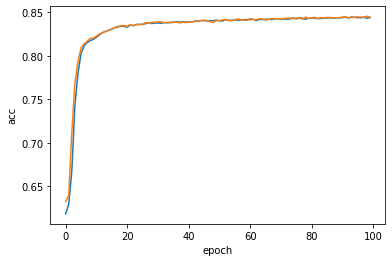

In [53]:
sns.lineplot(data = tb_eval, x = 'epoch', y = 'acc')
sns.lineplot(data = tb_eval, x = 'epoch', y = 'val_acc')